## Create water mask for later training the model
To generate the ground truth images we use the <code>create_gt</code> module. An example of the floodmap image retrieved for the flood in Sardinia, is shown. 

In [1]:
# Path based modules to allow us to save files to our local machine
from pyprojroot import here
import sys
import os
root = here(project_files=[".here"])
sys.path.append(str(here()))

import numpy as np
from datetime import timedelta
from datetime import datetime
import geopandas as gpd
import pandas as pd
import ee
import geemap.eefolium as geemap
import folium
from src.data import ee_download
from src.data.copernicusEMS import activations
from rasterio.plot import show as rasterio_show

from src.data import create_gt
from src.data.utils import GCPPath, load_json_from_bucket

In [25]:
temp = "ST_20170326_WaterExtent_OmusatiAndOshana0000000000-0000012544"
good = "EMSR286_08ITUANGONORTH_DEL_MONIT02_v1_observed_event_a"
bad = "EMSR261_03WOLFSBURG_DEL_MONIT05_v2_observed_event_a"
ml_stage = "train"

# S2 IMAGE
filename = f"0_DEV/2_Mart/worldfloods_v1_0/{ml_stage}/S2/{bad}"
bucket_name= "ml4cc_data_lake"
s2_image_path = f"gs://{bucket_name}/{filename}.tif"

print(s2_image_path)

gs://ml4cc_data_lake/0_DEV/2_Mart/worldfloods_v1_0/train/S2/EMSR261_03WOLFSBURG_DEL_MONIT05_v2_observed_event_a.tif


(3761, 7387)


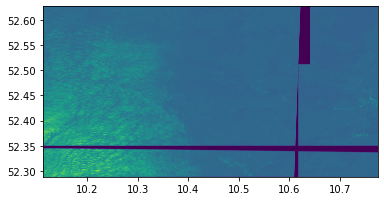

In [26]:
from src.data import create_gt
from rasterio import plot as rasterioplt
import numpy as np


import rasterio

image_name = f"gs://{bucket_name}/{filename}.tif"
with rasterio.open(s2_image_path) as src:
    print(src.shape)
#     image = src.read()
    transform = src.transform
    rasterioplt.show(src, transform=transform)

(3761, 7387)


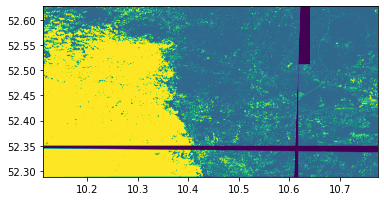

CPU times: user 1.71 s, sys: 114 ms, total: 1.83 s
Wall time: 2.41 s


In [27]:
%%time

# GT IMAGE
filename = f"0_DEV/2_Mart/worldfloods_v1_0/{ml_stage}/gt/{bad}"
bucket_name= "ml4cc_data_lake"
gt_image_path = f"gs://{bucket_name}/{filename}.tif"

with rasterio.open(gt_image_path) as src:
    print(src.shape)
#     image = src.read()
    transform = src.transform
    rasterioplt.show(src, transform=transform)

In [28]:


floodmap_geojson = "EMSR286_08ITUANGONORTH_DEL_MONIT02_v1_observed_event_a.geojson"
filename = f"0_DEV/2_Mart/worldfloods_v1_0/{ml_stage}/floodmap/{bad}"
floodmap_geojson_path = f"gs://{bucket_name}/{filename}.shp"

# water_mask = create_gt.compute_water(image_name, floodmap, keep_streams=True)
filename = f"0_DEV/2_Mart/worldfloods_v1_0/{ml_stage}/meta/{bad}"
floodmap_meta_path = f"{filename}.json"
floodmap_meta = load_json_from_bucket(bucket_name, floodmap_meta_path)

# water_mask = create_gt.compute_water(image_name, floodmap, keep_streams=True)
filename = f"0_DEV/2_Mart/worldfloods_v1_0/{ml_stage}/cloudprob/{bad}"
cloudprob_path = f"gs://{bucket_name}/{filename}.tif"


In [12]:
!gsutil ls gs://ml4cc_data_lake/0_DEV/2_Mart/worldfloods_v1_0/train/cloudprob/ST_20170326_WaterExtent_OmusatiAndOshana0000000000-0000012544.tif

gs://ml4cc_data_lake/0_DEV/2_Mart/worldfloods_v1_0/train/cloudprob/ST_20170326_WaterExtent_OmusatiAndOshana0000000000-0000012544.tif


In [29]:
%%time

from src.data.create_gt import generate_land_water_cloud_gt
gt, gt_meta = generate_land_water_cloud_gt(
                        s2_image_path,
                        floodmap_geojson_path,
                        keep_streams=True,
                        cloudprob_image_path=cloudprob_path,
#                         permanent_water_image_path=permenant_water_path,
                    )

CPU times: user 24.7 s, sys: 1.65 s, total: 26.3 s
Wall time: 43.2 s


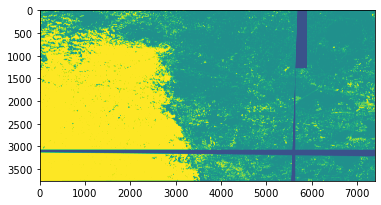

<AxesSubplot:>

In [30]:
rasterio_show(gt,vmin=-1, vmax=3)

In [ ]:
%%time

from src.data.create_gt import generate_water_cloud_binary_gt

gt, gt_meta = generate_water_cloud_binary_gt(
                        s2_image_path,
                        floodmap_geojson_path,
                        metadata_floodmap=floodmap_meta,
                        keep_streams=True,
                        cloudprob_image_path=cloudprob_path,
#                         permanent_water_image_path=permenant_water_path,
                    )

In [ ]:
rasterio_show(gt[0])

In [ ]:
rasterio_show(gt[1])

In [ ]:
gs://ml4cc_data_lake/0_DEV/2_Mart/worldfloods_v2_0/train/S2/ST_20170326_WaterExtent_OmusatiAndOshana0000000000-0000012544.tif

DriverError: HTTP response code: 404

In [3]:
water_mask.shape,np.unique(water_mask)

((384, 1012), array([-1,  0,  1,  2], dtype=int16))

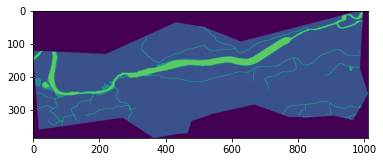

<AxesSubplot:>

In [4]:
rasterio_show(water_mask,vmin=-1, vmax=3)